In [94]:
import pandas as pd
import numpy as np
import os
import requests
import json
import datetime
import time
import matplotlib.pyplot as plt

# Episode Scraper
code taken from [here](https://www.kaggle.com/robga/google-football-episode-scraper)

In [95]:
# only parameters to modify
MIN_FINAL_RATING = 1300 # top submission in a match must have reached this score (initially at 500)
team_id = 5595843 #id for our team
team_id = 5645993 # another team

In [96]:
num_api_calls_today = 0
all_files = []
for root, dirs, files in os.walk('../input/', topdown=False):
    all_files.extend(files)
seen_episodes = [int(f.split('.')[0]) for f in all_files 
                      if '.' in f and f.split('.')[0].isdigit() and f.split('.')[1] == 'json']
print('{} games in existing library'.format(len(seen_episodes)))


42 games in existing library


In [97]:
NUM_TEAMS = 1
EPISODES = 600 

BUFFER = 1

base_url = "https://www.kaggle.com/requests/EpisodeService/"
get_url = base_url + "GetEpisodeReplay"
list_url = base_url + "ListEpisodes"

In [98]:
# inital team list
r = requests.post(list_url, json = {"teamId":  5586412}) # arbitrary ID, change to leading ID during challenge
rj = r.json()
teams_df = pd.DataFrame(rj['result']['teams'])
teams_df.sort_values('publicLeaderboardRank', inplace = True)
teams_df.head()

,id,teamName,competitionId,teamLeaderId,isBenchmark,createdAfterDeadline,medal,dateMedalAwarded,submissionCount,lastSubmissionDate,publicLeaderboardSubmissionId,publicLeaderboardScore,publicLeaderboardRank,privateLeaderboardSubmissionId,privateLeaderboardScore,privateLeaderboardRank,competition,teamMembers,inboundMergeRequests,outboundMergeRequests
371,5645993,s_shohei,21723,2304617,False,False,0,None,42,"{'seconds': 1604379662, 'nanos': 670000000}",17723049,None,3.0,None,None,None,None,"[{'id': 2304617, 'displayName': 's_shohei', 'e...",[],[]
84,5588536,WFC,21723,1297333,False,False,0,None,57,"{'seconds': 1604366521, 'nanos': 826666700}",17803421,None,4.0,None,None,None,None,"[{'id': 1297333, 'displayName': 'NQ', 'email':...",[],[]
383,5655996,zsp1197 zsp,21723,5941019,False,False,0,None,9,"{'seconds': 1604377734, 'nanos': 466666700}",17569597,None,5.0,None,None,None,None,"[{'id': 5941019, 'displayName': 'zsp1197 zsp',...",[],[]
54,5587525,aDg4b,21723,2658609,False,False,0,None,10,"{'seconds': 1602799397, 'nanos': 106666700}",17515439,None,6.0,None,None,None,None,"[{'id': 2658609, 'displayName': 'aDg4b', 'emai...",[],[]
53,5587512,pigzz,21723,989207,False,False,0,None,20,"{'seconds': 1604387920, 'nanos': 856666700}",17843895,None,8.0,None,None,None,None,"[{'id': 989207, 'displayName': 'pigzz', 'email...",[],[]


In [99]:
teams_df.loc[teams_df['teamName']=='WeKick']

,id,teamName,competitionId,teamLeaderId,isBenchmark,createdAfterDeadline,medal,dateMedalAwarded,submissionCount,lastSubmissionDate,publicLeaderboardSubmissionId,publicLeaderboardScore,publicLeaderboardRank,privateLeaderboardSubmissionId,privateLeaderboardScore,privateLeaderboardRank,competition,teamMembers,inboundMergeRequests,outboundMergeRequests


In [100]:
def getTeamEpisodes(team_id):
    # request
    r = requests.post(list_url, json = {"teamId":  int(team_id)})
    rj = r.json()

    # update teams list
    global teams_df
    teams_df_new = pd.DataFrame(rj['result']['teams'])
    
    if len(teams_df.columns) == len(teams_df_new.columns) and (teams_df.columns == teams_df_new.columns).all():
        teams_df = pd.concat( (teams_df, teams_df_new.loc[[c for c in teams_df_new.index if c not in teams_df.index]] ) )
        teams_df.sort_values('publicLeaderboardRank', inplace = True)
    else:
        print('teams dataframe did not match')
    
    # make df
    team_episodes = pd.DataFrame(rj['result']['episodes'])
    team_episodes['avg_score'] = -1;
    
    for i in range(len(team_episodes)):
        agents = team_episodes['agents'].loc[i]
        agent_scores = [a['updatedScore'] for a in agents if a['updatedScore'] is not None]
        team_episodes.loc[i, 'submissionId'] = [a['submissionId'] for a in agents if a['submission']['teamId'] == team_id][0]
        team_episodes.loc[i, 'updatedScore'] = [a['updatedScore'] for a in agents if a['submission']['teamId'] == team_id][0]
        
        if len(agent_scores) > 0:
            team_episodes.loc[i, 'avg_score'] = np.mean(agent_scores)

    for sub_id in team_episodes['submissionId'].unique():
        sub_rows = team_episodes[ team_episodes['submissionId'] == sub_id ]
        max_time = max( [r['seconds'] for r in sub_rows['endTime']] )
        final_score = max( [r['updatedScore'] for r_idx, (r_index, r) in enumerate(sub_rows.iterrows())
                                if r['endTime']['seconds'] == max_time] )

        team_episodes.loc[sub_rows.index, 'final_score'] = final_score
        
    team_episodes.sort_values('avg_score', ascending = False, inplace=True)
    return rj, team_episodes

In [101]:
def saveEpisode(epid, rj):
    # request
    re = requests.post(get_url, json = {"EpisodeId": int(epid)})
        
    # save replay
    with open('{}.json'.format(epid), 'w') as f:
        f.write(re.json()['result']['replay'])

    # save episode info
    with open('{}_info.json'.format(epid), 'w') as f:
        json.dump([r for r in rj['result']['episodes'] if r['id']==epid][0], f)

In [102]:
global num_api_calls_today

pulled_teams = {}
pulled_episodes = []
start_time = datetime.datetime.now()
r = BUFFER;

team_json, team_df = getTeamEpisodes(team_id); r+=1;
num_api_calls_today+=1
print('{} games for {}'.format(len(team_df), teams_df.loc[teams_df.id == team_id].iloc[0].teamName))


team_df = team_df[  (MIN_FINAL_RATING is None or (team_df.final_score > MIN_FINAL_RATING))]

print('   {} in score range from {} submissions'.format(len(team_df), len(team_df.submissionId.unique() ) ) )

team_df = team_df[~team_df.id.isin(pulled_episodes + seen_episodes)]        
print('      {} remain to be downloaded\n'.format(len(team_df)))

# pull games
target_team_games = int(np.ceil(EPISODES / NUM_TEAMS))
if target_team_games + len(pulled_episodes) > EPISODES:
    target_team_games = EPISODES - len(pulled_episodes)

pulled_teams[team_id] = 0

i = 0
while i < len(team_df) and pulled_teams[team_id] < target_team_games:
    epid = team_df.id.iloc[i]
    if not (epid in pulled_episodes or epid in seen_episodes):
        try:
            saveEpisode(epid, team_json); r+=1;
            num_api_calls_today+=1
        except:
            time.sleep(20)
            i+=1;
            continue;

        pulled_episodes.append(epid)
        pulled_teams[team_id] += 1
        try:
            size = os.path.getsize('{}.json'.format(epid)) / 1e6
            print(str(num_api_calls_today) + ': Saved Episode #{} @ {:.1f}MB'.format(epid, size))
        except:
            print('  file {}.json did not seem to save'.format(epid))    
        if r > (datetime.datetime.now() - start_time).seconds:
            time.sleep( r - (datetime.datetime.now() - start_time).seconds)
    i+=1

4205 games for s_shohei
   592 in score range from 9 submissions
      592 remain to be downloaded

2: Saved Episode #4227798 @ 21.1MB
3: Saved Episode #4217630 @ 21.2MB
4: Saved Episode #4231147 @ 21.3MB
5: Saved Episode #4215231 @ 21.5MB
6: Saved Episode #4247095 @ 21.5MB
7: Saved Episode #4228366 @ 21.2MB
8: Saved Episode #4196540 @ 21.4MB
9: Saved Episode #4189467 @ 21.3MB
10: Saved Episode #4249764 @ 21.3MB
11: Saved Episode #4181538 @ 21.4MB
12: Saved Episode #4174131 @ 21.0MB
13: Saved Episode #4129498 @ 20.9MB
14: Saved Episode #4251306 @ 21.3MB
15: Saved Episode #4141654 @ 21.2MB
16: Saved Episode #4201167 @ 21.4MB
17: Saved Episode #4081637 @ 21.3MB
18: Saved Episode #4159527 @ 21.4MB


KeyboardInterrupt: 

# Json Analysis

In [103]:
# must manually enter the id of the game to extract
# 4175495 -- 2-1 win
with open('./4251306.json') as f:
    data = json.load(f)

## initial data analysis
just a bunch of json prints to see the structure of the data and see what can be useful

In [104]:
print(data.keys())
print(data['configuration'].keys())
data['info']

dict_keys(['configuration', 'description', 'id', 'info', 'name', 'rewards', 'schema_version', 'specification', 'statuses', 'steps', 'title', 'version'])
dict_keys(['actTimeout', 'agentTimeout', 'episodeSteps', 'id', 'isProduction', 'logdir', 'render', 'runTimeout', 'running_in_notebook', 'save_video', 'scenario_name', 'team_1', 'team_2'])


{'EpisodeId': 4251306,
 'LiveVideoPath': '/kaggle_simulations/out.webm',
 'TeamNames': ['WeKick', 's_shohei']}

In [105]:
print(data['specification'].keys())
print(data['specification']['reward'])
data['specification']['configuration']

dict_keys(['action', 'agents', 'configuration', 'info', 'observation', 'reward'])
{'default': 0, 'description': '1.0 for scored goal, -1.0 for lost goal (it is given only when the goal is scored, and changes back to 0 afterwards)', 'type': ['number', 'null']}


{'actTimeout': {'default': 0.5,
  'description': 'Maximum runtime (seconds) to obtain an action from an agent.',
  'minimum': 0,
  'type': 'number'},
 'agentTimeout': {'default': 60,
  'description': 'Maximum runtime (seconds) to initialize an agent.',
  'minimum': 0,
  'type': 'number'},
 'episodeSteps': {'default': 3002,
  'description': 'Maximum number of steps in the episode.',
  'minimum': 1,
  'type': 'integer'},
 'id': {'default': None,
  'description': 'Id of this environment run, a random uuid.',
  'type': 'string'},
 'isProduction': {'default': False,
  'description': "Whether this episode is running in Kaggle's production evaluation system. Undefined behavior when set to True locally.",
  'type': 'boolean'},
 'logdir': {'default': '/tmp/football',
  'description': 'Directory to write the state dump and video information.',
  'type': 'string'},
 'render': {'default': False,
  'description': 'If true - renders the game on the screen. This option will work on your local compute

In [106]:
data['steps'][542]

[{'action': [5],
  'info': {},
  'observation': {'controlled_players': 1,
   'players_raw': [{'active': 8,
     'ball': [-0.383198082447052, -0.2469089776277542, 0.1185900866985321],
     'ball_direction': [0.007529512047767639,
      0.0004050762508995831,
      0.018765239045023918],
     'ball_owned_player': 8,
     'ball_owned_team': 0,
     'ball_rotation': [6.867681804578751e-06,
      -1.7631295122555457e-05,
      -8.298401326101157e-07],
     'designated': 8,
     'game_mode': 0,
     'left_team': [[-0.8499166369438171, -0.06547009944915771],
      [-0.6611815094947815, -0.2121652215719223],
      [-0.5762208700180054, -0.09456691145896912],
      [-0.6825299263000488, -0.05268124118447304],
      [-0.5974001288414001, 0.20751430094242096],
      [-0.6885280609130859, -0.1382497102022171],
      [-0.3010299503803253, -0.17717953026294708],
      [-0.2829616963863373, 0.060961343348026276],
      [-0.3873533308506012, -0.25028201937675476],
      [0.20446139574050903, -0.057738

In [107]:
print(data['steps'][0][0].keys())
data['steps'][0][0]['observation']['players_raw'][0]

dict_keys(['action', 'info', 'observation', 'reward', 'status'])


{'active': 6,
 'ball': [0.0, -0.0, 0.11061639338731766],
 'ball_direction': [0.0, -0.0, 0.006163952872157097],
 'ball_owned_player': -1,
 'ball_owned_team': -1,
 'ball_rotation': [0.0, -0.0, 0.0],
 'designated': 6,
 'game_mode': 0,
 'left_team': [[-1.0110293626785278, -0.0],
  [-0.4266543984413147, -0.19894461333751678],
  [-0.5055146813392639, -0.06459399312734604],
  [-0.5055146813392639, 0.06459297984838486],
  [-0.4266543984413147, 0.19894461333751678],
  [-0.18624374270439148, -0.10739918798208237],
  [-0.270525187253952, -0.0],
  [-0.18624374270439148, 0.10739918798208237],
  [-0.010110294446349144, -0.21961550414562225],
  [-0.05055147036910057, -0.0],
  [-0.010110294446349144, 0.21961753070354462]],
 'left_team_active': [True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True],
 'left_team_direction': [[0.0, -0.0],
  [0.0, -0.0],
  [0.0, -0.0],
  [0.0, -0.0],
  [0.0, -0.0],
  [0.0, -0.0],
  [0.0, -0.0],
  [0.0, -0.0],
  [0.0, -0.0],
  [0.0, -0.0],
 

In [108]:
len(data['steps'])

3002

## get team index in the file
can either be home (0) or away (1) team.

In [110]:
print(data['info']['TeamNames'])
#team_index = data['info']['TeamNames'].index("Artificial Stupidity FC")
team_index = data['info']['TeamNames'].index("s_shohei")

['WeKick', 's_shohei']


## get total possession (simple way)

In [111]:
# loop through all the steps of the match and record the team that owns the ball
def get_total_pos():
    pos = {}
    pos_percent = {-1:list(), 1:list(), 0:list()}
    for i in range(len(data['steps'])):
        cur_pos = data['steps'][i][0]['observation']['players_raw'][0]['ball_owned_team']
        if(cur_pos in pos):
            pos[cur_pos] += 1
        else:
            pos[cur_pos] = 1
        #below get the evolutive percentages
        try:
            pos_percent[-1].append([i, pos[-1] / sum(pos.values())])
        except:
            pos_percent[-1].append([i,0])
        try:
            pos_percent[1].append([i, pos[1] / sum(pos.values())])
            #pos_percent[1].append([i, pos[1] / (np.sum(np.array(pos_percent[0])[:,1])+np.sum(np.array(pos_percent[1])[:,1]))])
        except:
            pos_percent[1].append([i,0])
        try:
            pos_percent[0].append([i, pos[0] / sum(pos.values())])
            #pos_percent[0].append([i, pos[0] / (np.sum(np.array(pos_percent[0])[:,1])+np.sum(np.array(pos_percent[1])[:,1]))])
        except:
            pos_percent[0].append([i,0])
    return pos, pos_percent

In [112]:
total_pos, pos_percentages = get_total_pos()
total_pos

{-1: 1433, 1: 1002, 0: 567}

In [113]:
# transform data to get the possession at each step for out team
team_perc = np.array(pos_percentages[team_index])
t_steps = team_perc[:,0]
t_pos = team_perc[:,1]

## get the total possession (complex way)
In the game, when a pass is made, no team owns the ball while le ball is between the two players (the possession is -1). So we try here to integrate this in order to have a more precise possession calculation.

In [114]:
# we test our logic with a simple array:
# - one successful pass for team 1,
# - one missed pass for team 2,
# - one successful pass for team 2
# a successful pass: the team id (ball passed), a succession of -1, the team id (ball received)
test = [-1,1,-1,-1,1,2,-1,-1,1,1,2,-1,2]
pos = {}
i = 0
while i < len(test):
    cur_pos = test[i]
    if(cur_pos in pos):
        pos[cur_pos] += 1
    else:
        pos[cur_pos] = 1
    j = i+1
    if j == len(test):
        break
    if cur_pos != -1 and test[j] == -1:
        pass_steps = 0
        while test[j] == -1:
            j += 1
            pass_steps += 1
        if test[j] == cur_pos:
            pos[cur_pos] += pass_steps
        else:
            pos[-1] += pass_steps
        i = j
    else:
        i+=1
pos

{-1: 3, 1: 6, 2: 4}

In [115]:
# try the same logic on real data
pos = {}
team_pos = {}
passes_completed = {1:list(), 0:list()}
i = 0
while i < len(data['steps']):
    cur_pos = data['steps'][i][0]['observation']['players_raw'][0]['ball_owned_team']
    if(cur_pos in pos):
        pos[cur_pos] += 1
    else:
        pos[cur_pos] = 1
    j = i+1
    if j >= len(data['steps']):
        break
    if cur_pos != -1 and data['steps'][j][0]['observation']['players_raw'][0]['ball_owned_team'] == -1:
        pass_steps = 0
        while data['steps'][j][0]['observation']['players_raw'][0]['ball_owned_team'] == -1:
            j += 1
            pass_steps += 1
            if j >= len(data['steps']):
                break
        if j >= len(data['steps']):
                pos[-1] += pass_steps
                break
        if data['steps'][j][0]['observation']['players_raw'][0]['ball_owned_team'] == cur_pos:
            pos[cur_pos] += pass_steps
            passes_completed[cur_pos].append(j)
        else:
            pos[-1] += pass_steps
        i = j
    else:
        i+=1
    try:
        team_pos[i] = pos[team_index]
    except:
        team_pos[i] = 0
pos

{-1: 626, 1: 1547, 0: 829}

## evolution of team possession

In [116]:
# record our team's possession at each step of the match
def get_evolutive_possession():
    t_evol = {}
    pos = 0
    for i in range(len(data['steps'])):
        cur_pos = data['steps'][i][0]['observation']['players_raw'][0]['ball_owned_team']
        if cur_pos == team_index:
            pos += 1
        t_evol[i] = pos
    return t_evol

In [117]:
pos_evolution = get_evolutive_possession()

## total possession per player for each team

In [118]:
# returns a tuple of two dictionaries containing the number of touches per player on each team
def get_player_possessions():
    pos = [{},{}]
    for i in range(len(data['steps'])):
        cur_player = data['steps'][i][0]['observation']['players_raw'][0]['ball_owned_player']
        cur_team = data['steps'][i][0]['observation']['players_raw'][0]['ball_owned_team']
        if cur_team == -1:
            continue
        if(cur_player in pos[cur_team]):
            pos[cur_team][cur_player] += 1
        else:
            pos[cur_team][cur_player] = 1
    return pos

In [119]:
player_pos = get_player_possessions()
print('player possession for home team:', player_pos[0])
print('player possession for away team:', player_pos[1])
print('sum of home players touches:', sum(player_pos[0].values()))
print('sum of away players touches:', sum(player_pos[1].values()))

player possession for home team: {5: 39, 2: 40, 9: 74, 0: 99, 3: 28, 8: 221, 1: 58, 6: 8}
player possession for away team: {9: 267, 8: 55, 3: 59, 5: 83, 2: 62, 4: 141, 6: 39, 1: 5, 10: 160, 7: 120, 0: 11}
sum of home players touches: 567
sum of away players touches: 1002


## scores and modes of the game
see what's going on in the games (as dictionaries)
the modes are the different types of actions possible (normal, throw-in, penalty...) see [here](https://github.com/google-research/football/blob/master/gfootball/doc/observation.md) <br>
the scores are the number of steps for each score <br>
the goal evolution is the number of goals scored by our team at each step

In [120]:
modes = {}
scores = {}
goals_evolution = {}
for i in range(len(data['steps'])):
    cur_mode = data['steps'][i][0]['observation']['players_raw'][0]['game_mode']
    cur_score = data['steps'][i][0]['observation']['players_raw'][0]['score']
    s = str(cur_score[0]) + '-' + str(cur_score[1])
    if(cur_mode in modes):
        modes[cur_mode] += 1
    else:
        modes[cur_mode] = 1
    if s in scores:
        scores[s] += 1
    else:
        scores[s] = 1
    goals_evolution[i] = cur_score[team_index]
print(modes)
print(scores)

{0: 2885, 2: 33, 5: 16, 4: 26, 3: 42}
{'0-0': 1243, '0-1': 105, '0-2': 524, '0-3': 1108, '0-4': 22}


## actions during the match
couts the number of occurences for each type of action. see [here](https://github.com/google-research/football/blob/master/gfootball/doc/observation.md)

In [121]:
actions_counter = {-1:0}
total_shots = 0
shots = {}
total_passes = 0
passes = {}
for i in range(len(data['steps'])):
    try:
        a = data['steps'][i][team_index]['action'][0]
    except:
        actions_counter[-1] += 1
        continue
    if a in actions_counter:
        actions_counter[a] += 1
    else:
        actions_counter[a] = 1
    if a == 12: #shot
        total_shots += 1
        shots[i] = total_shots
    if a == 9 or a == 10 or a == 11: #all types of passes
        total_passes += 1
        passes[i] = total_passes
actions_counter

{-1: 1,
 5: 485,
 18: 1141,
 0: 258,
 4: 87,
 3: 81,
 2: 81,
 13: 137,
 8: 90,
 7: 75,
 6: 96,
 1: 209,
 12: 78,
 15: 34,
 9: 91,
 14: 17,
 10: 16,
 11: 25}

# Plots

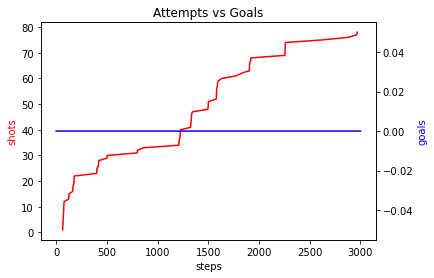

In [122]:
fig,ax = plt.subplots()
ax.plot(list(shots.keys()),list(shots.values()), color='red', label='shots')
ax2=ax.twinx()
ax2.plot(list(goals_evolution.keys()),list(goals_evolution.values()), color='blue', label='goals')
ax.set_ylabel("shots", color='red')
ax2.set_ylabel("goals", color='blue')
ax.set_xlabel("steps")
plt.title("Attempts vs Goals")
plt.show()

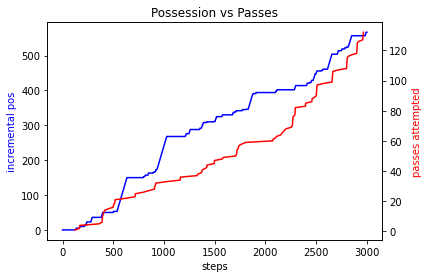

In [123]:
fig,ax = plt.subplots()
ax.plot(list(pos_evolution.keys()), list(pos_evolution.values()), color='blue')
ax2=ax.twinx()
ax2.plot(list(passes.keys()), list(passes.values()), color='red')
ax.set_ylabel("incremental pos", color='blue')
ax2.set_ylabel("passes attempted", color='red')
ax.set_xlabel("steps")
plt.title("Possession vs Passes")
plt.show()

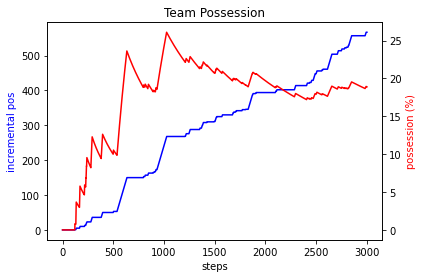

In [124]:
fig,ax = plt.subplots()
ax.plot(list(pos_evolution.keys()), list(pos_evolution.values()), color='blue')
ax2=ax.twinx()
ax2.plot(t_steps, t_pos*100, color='red')
ax.set_ylabel("incremental pos", color='blue')
ax2.set_ylabel("possession (%)", color='red')
ax.set_xlabel("steps")
plt.title("Team Possession")
plt.show()

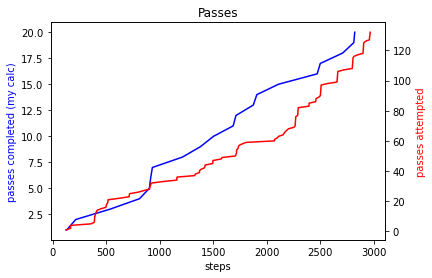

In [125]:
passes_times = passes_completed[0]
passes_compl = np.arange(1,len(passes_times)+1)
fig,ax = plt.subplots()
ax.plot(passes_times, passes_compl, color='blue')
ax2=ax.twinx()
ax2.plot(list(passes.keys()), list(passes.values()), color='red')
ax.set_ylabel("passes completed (my calc)", color='blue')
ax2.set_ylabel("passes attempted", color='red')
ax.set_xlabel("steps")
plt.title("Passes")
plt.show()

## positions of the players (work in progress)
players heatmaps

In [126]:
data['steps'][0][0]['observation']['players_raw'][0]['left_team_roles']

[0, 2, 1, 1, 3, 5, 5, 5, 6, 9, 7]

In [127]:
#coordinates of the field
bounds = [100,-100,100,-100]
for i in range(len(data['steps'])):
    for j in range(len(data['steps'][0][0]['observation']['players_raw'][0]['left_team_roles'])):
        pos = data['steps'][i][0]['observation']['players_raw'][0]['left_team'][j]
        if pos[0] < bounds[0]:
            bounds[0] = pos[0]
        if pos[0] > bounds[1]:
            bounds[1] = pos[0]
        if pos[1] < bounds[2]:
            bounds[2] = pos[1]
        if pos[1] > bounds[3]:
            bounds[3] = pos[1]
bounds

[-1.0208297967910767,
 1.0252909660339355,
 -0.44360169768333435,
 0.3493885397911072]

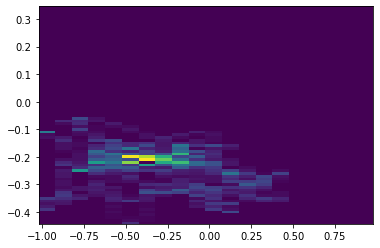

In [128]:
#heatmap of 7 (RM)
positions = []
for i in range(len(data['steps'])):
    positions.append(data['steps'][i][0]['observation']['players_raw'][0]['left_team'][1])
np_pos = np.array(positions)
x = np_pos[:,0]
y = np_pos[:,1]
plt.hist2d(x,y, bins=[np.arange(bounds[0],bounds[1],0.1),np.arange(bounds[2],bounds[3],0.01)])
plt.show()

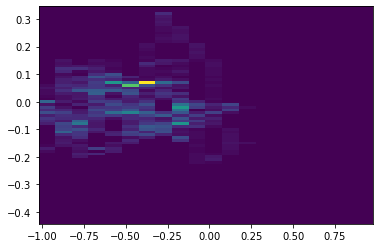

In [129]:
#heatmap of 2 (LB)
positions = []
for i in range(len(data['steps'])):
    positions.append(data['steps'][i][0]['observation']['players_raw'][0]['left_team'][3])
np_pos = np.array(positions)
x = np_pos[:,0]
y = np_pos[:,1]
plt.hist2d(x,y, bins=[np.arange(bounds[0],bounds[1],0.1),np.arange(bounds[2],bounds[3],0.01)])
plt.show()